In [1]:
import os
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch import optim
import torchvision.utils as torch_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generator and Discriminator Utilities
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
    

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x
    
def target_to_oh_shoe(target):
    NUM_CLASS = 5
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot


# Train and Eval utilities
def generate_examples(gen, steps, z_dim, n=100):
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, z_dim).to(device)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

  
def gradient_penalty(critic, labels, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def get_loader(image_size):
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(channels_img)],
            [0.5 for _ in range(channels_img)],
         )
        ]
    )
    batch_size = batch_sizes[int(math.log2(image_size/4))]
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform, target_transform = target_to_oh_shoe)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

def check_loader():
    loader, _ = get_loader(128)
    cloth, _  = next(iter(loader))
    _, ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1

In [2]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Same as ProGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3, classes=5):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(classes, 1*4*4)

        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(image_factors) - 1, 0, -1):
            conv_in = int(in_channels * image_factors[i])
            conv_out = int(in_channels * image_factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, label, alpha, steps):
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         x = torch.concat((x, label_embedding), dim=1)
        x = x + label_embedding
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [3]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Normalization on every element of input vector
# Adapted from StyleGAN original Implementation
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
    
# Implementing the Noise Mapping Network
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features,
    ):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2 / in_features)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        # initialize linear layer
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.linear(x * self.scale) + self.bias
    

class NoiseMappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.noise_mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self, x):
        return self.noise_mapping(x)
    

# Adaptive Instance Normalization (AdaIn)
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale = WSLinear(w_dim, channels)
        self.style_bias = WSLinear(w_dim, channels)

    def forward(self, x, w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias
    

class NoiseInjectNet(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = NoiseInjectNet(out_channels)
        self.inject_noise2 = NoiseInjectNet(out_channels)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3, classes=5):
        super(Generator, self).__init__()
        self.embedding = nn.Linear(classes, 4*4)

        self.starting_constant = nn.Parameter(torch.ones((1, in_channels, 4, 4)))
        self.map = NoiseMappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = NoiseInjectNet(in_channels)
        self.initial_noise2 = NoiseInjectNet(in_channels)
        self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(len(image_factors) - 1):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * image_factors[i])
            conv_out_c = int(in_channels * image_factors[i + 1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, noise, label, alpha, steps):
#         print(label.shape)
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_constant), w)
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         print(x.shape, label_embedding.shape)
#         x = torch.concat((x, label_embedding), dim = 1)
        x = x + label_embedding
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
            out = self.prog_blocks[step](upscaled, w)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)



Curent image size: 4


  5%|▌         | 1/20 [00:02<00:53,  2.80s/it, disc_loss=-1.71, grad_penalty=0.0222]

[0/15][0/20]	Loss_D: -1.7060374021530151	Loss_G: 4.491273880004883


  5%|▌         | 1/20 [00:00<00:08,  2.17it/s, disc_loss=-274, grad_penalty=0.772]

[1/15][0/20]	Loss_D: -273.844970703125	Loss_G: 375.0459899902344


  5%|▌         | 1/20 [00:00<00:08,  2.28it/s, disc_loss=-140, grad_penalty=3.5]

[2/15][0/20]	Loss_D: -139.50563049316406	Loss_G: 193.43128967285156


  5%|▌         | 1/20 [00:00<00:14,  1.30it/s, disc_loss=-52.3, grad_penalty=4.33]

[3/15][0/20]	Loss_D: -52.30851745605469	Loss_G: 104.57430267333984


  5%|▌         | 1/20 [00:00<00:08,  2.13it/s, disc_loss=-28.2, grad_penalty=3.74]

[4/15][0/20]	Loss_D: -28.22249984741211	Loss_G: 72.6624755859375


  5%|▌         | 1/20 [00:00<00:09,  2.11it/s, disc_loss=-21.9, grad_penalty=2.14]

[5/15][0/20]	Loss_D: -21.940834045410156	Loss_G: 48.653175354003906


  5%|▌         | 1/20 [00:00<00:09,  2.08it/s, disc_loss=-18.3, grad_penalty=1.51]

[6/15][0/20]	Loss_D: -18.255615234375	Loss_G: 37.556304931640625


  5%|▌         | 1/20 [00:00<00:14,  1.32it/s, disc_loss=-11.9, grad_penalty=0.929]

[7/15][0/20]	Loss_D: -11.948749542236328	Loss_G: 24.721240997314453


  5%|▌         | 1/20 [00:00<00:08,  2.14it/s, disc_loss=-16.7, grad_penalty=0.777]

[8/15][0/20]	Loss_D: -16.720380783081055	Loss_G: 27.143566131591797


  5%|▌         | 1/20 [00:00<00:08,  2.13it/s, disc_loss=-14.2, grad_penalty=0.58]

[9/15][0/20]	Loss_D: -14.164701461791992	Loss_G: 21.998620986938477


  5%|▌         | 1/20 [00:00<00:09,  1.97it/s, disc_loss=-14.7, grad_penalty=0.536]

[10/15][0/20]	Loss_D: -14.748518943786621	Loss_G: 21.812307357788086


  5%|▌         | 1/20 [00:00<00:09,  1.95it/s, disc_loss=-15.9, grad_penalty=0.506]

[11/15][0/20]	Loss_D: -15.929530143737793	Loss_G: 22.41309928894043


  5%|▌         | 1/20 [00:00<00:15,  1.26it/s, disc_loss=-20.4, grad_penalty=0.56]

[12/15][0/20]	Loss_D: -20.381790161132812	Loss_G: 27.29092788696289


  5%|▌         | 1/20 [00:00<00:08,  2.16it/s, disc_loss=-19.5, grad_penalty=0.594]

[13/15][0/20]	Loss_D: -19.537433624267578	Loss_G: 26.582916259765625


  5%|▌         | 1/20 [00:00<00:08,  2.15it/s, disc_loss=-20.2, grad_penalty=0.559]

[14/15][0/20]	Loss_D: -20.20722770690918	Loss_G: 26.741519927978516


100%|██████████| 20/20 [00:10<00:00,  1.87it/s, disc_loss=-16, grad_penalty=0.489]


Curent image size: 8


  2%|▎         | 1/40 [00:00<00:19,  2.04it/s, disc_loss=-5.29, grad_penalty=0.0411]

[0/15][0/40]	Loss_D: -5.29296875	Loss_G: 6.756929397583008


  2%|▎         | 1/40 [00:00<00:17,  2.18it/s, disc_loss=-6.72, grad_penalty=0.161]

[1/15][0/40]	Loss_D: -6.717966079711914	Loss_G: 11.81601619720459


  2%|▎         | 1/40 [00:00<00:31,  1.22it/s, disc_loss=-4.66, grad_penalty=0.0997]

[2/15][0/40]	Loss_D: -4.663121223449707	Loss_G: 10.639114379882812


  2%|▎         | 1/40 [00:00<00:18,  2.06it/s, disc_loss=-3.7, grad_penalty=0.0217]

[3/15][0/40]	Loss_D: -3.701786994934082	Loss_G: 8.090601921081543


  2%|▎         | 1/40 [00:00<00:17,  2.18it/s, disc_loss=-3.26, grad_penalty=0.0191]

[4/15][0/40]	Loss_D: -3.264456033706665	Loss_G: 10.715232849121094


  2%|▎         | 1/40 [00:00<00:18,  2.12it/s, disc_loss=-3.92, grad_penalty=0.0919]

[5/15][0/40]	Loss_D: -3.9213154315948486	Loss_G: 6.352998733520508


  2%|▎         | 1/40 [00:00<00:17,  2.17it/s, disc_loss=-3.23, grad_penalty=0.0413]

[6/15][0/40]	Loss_D: -3.226083517074585	Loss_G: 7.933347702026367


  2%|▎         | 1/40 [00:00<00:18,  2.14it/s, disc_loss=-3.19, grad_penalty=0.0507]

[7/15][0/40]	Loss_D: -3.185718059539795	Loss_G: 7.471133708953857


  2%|▎         | 1/40 [00:00<00:17,  2.23it/s, disc_loss=-2.97, grad_penalty=0.0113]

[8/15][0/40]	Loss_D: -2.966506004333496	Loss_G: 8.872446060180664


  2%|▎         | 1/40 [00:00<00:17,  2.19it/s, disc_loss=-1.89, grad_penalty=0.0113]

[9/15][0/40]	Loss_D: -1.8876712322235107	Loss_G: 7.054489612579346


  2%|▎         | 1/40 [00:00<00:18,  2.07it/s, disc_loss=-2.72, grad_penalty=0.158]

[10/15][0/40]	Loss_D: -2.7155957221984863	Loss_G: 2.4334096908569336


  2%|▎         | 1/40 [00:00<00:18,  2.15it/s, disc_loss=-1.57, grad_penalty=0.0309]

[11/15][0/40]	Loss_D: -1.572250485420227	Loss_G: 6.291515827178955


  2%|▎         | 1/40 [00:00<00:17,  2.20it/s, disc_loss=-3.19, grad_penalty=0.0371]

[12/15][0/40]	Loss_D: -3.1917991638183594	Loss_G: 5.693147659301758


  2%|▎         | 1/40 [00:00<00:17,  2.21it/s, disc_loss=-3.36, grad_penalty=0.0287]

[13/15][0/40]	Loss_D: -3.3560075759887695	Loss_G: 6.920656204223633


  2%|▎         | 1/40 [00:00<00:17,  2.17it/s, disc_loss=-2.21, grad_penalty=0.0458]

[14/15][0/40]	Loss_D: -2.206385850906372	Loss_G: 6.383028984069824


100%|██████████| 40/40 [00:19<00:00,  2.06it/s, disc_loss=-2.55, grad_penalty=0.0773]


Curent image size: 16


  1%|▏         | 1/79 [00:00<00:32,  2.38it/s, disc_loss=0.316, grad_penalty=0.232]

[0/15][0/79]	Loss_D: 0.3163495659828186	Loss_G: 8.232123374938965


 65%|██████▍   | 51/79 [00:21<00:13,  2.10it/s, disc_loss=-4.57, grad_penalty=0.11]

[0/15][50/79]	Loss_D: -4.5746235847473145	Loss_G: 11.811824798583984


  1%|▏         | 1/79 [00:00<00:30,  2.59it/s, disc_loss=-4.44, grad_penalty=0.0273]

[1/15][0/79]	Loss_D: -4.435088157653809	Loss_G: 12.515087127685547


 65%|██████▍   | 51/79 [00:20<00:10,  2.57it/s, disc_loss=-5.85, grad_penalty=0.251]

[1/15][50/79]	Loss_D: -5.854874134063721	Loss_G: 7.225635528564453


  1%|▏         | 1/79 [00:00<00:30,  2.55it/s, disc_loss=-3.68, grad_penalty=0.072]

[2/15][0/79]	Loss_D: -3.6760334968566895	Loss_G: 5.5355329513549805


 65%|██████▍   | 51/79 [00:21<00:11,  2.35it/s, disc_loss=-3.34, grad_penalty=0.0201]

[2/15][50/79]	Loss_D: -3.3369147777557373	Loss_G: 5.379179954528809


  1%|▏         | 1/79 [00:00<00:29,  2.62it/s, disc_loss=-0.799, grad_penalty=0.03]

[3/15][0/79]	Loss_D: -0.7992026805877686	Loss_G: 4.157162666320801


 65%|██████▍   | 51/79 [00:20<00:10,  2.58it/s, disc_loss=-3.54, grad_penalty=0.0166]

[3/15][50/79]	Loss_D: -3.538966417312622	Loss_G: 7.27131986618042


  1%|▏         | 1/79 [00:00<00:30,  2.58it/s, disc_loss=-5.48, grad_penalty=0.0566]

[4/15][0/79]	Loss_D: -5.482237339019775	Loss_G: 19.427560806274414


 65%|██████▍   | 51/79 [00:20<00:11,  2.40it/s, disc_loss=-5.63, grad_penalty=0.0943]

[4/15][50/79]	Loss_D: -5.626511573791504	Loss_G: 9.060726165771484


  1%|▏         | 1/79 [00:00<01:09,  1.12it/s, disc_loss=-4.08, grad_penalty=0.243]

[5/15][0/79]	Loss_D: -4.082444667816162	Loss_G: 4.290584564208984


 65%|██████▍   | 51/79 [00:21<00:10,  2.57it/s, disc_loss=-3.87, grad_penalty=0.124]

[5/15][50/79]	Loss_D: -3.870823860168457	Loss_G: 5.319068431854248


  1%|▏         | 1/79 [00:00<00:29,  2.63it/s, disc_loss=-3.52, grad_penalty=0.0459]

[6/15][0/79]	Loss_D: -3.5213522911071777	Loss_G: 8.002668380737305


 65%|██████▍   | 51/79 [00:20<00:15,  1.86it/s, disc_loss=-3.7, grad_penalty=0.114]

[6/15][50/79]	Loss_D: -3.7039716243743896	Loss_G: 4.920564651489258


  1%|▏         | 1/79 [00:00<00:30,  2.55it/s, disc_loss=-5.12, grad_penalty=0.0567]

[7/15][0/79]	Loss_D: -5.119879245758057	Loss_G: 11.541350364685059


 65%|██████▍   | 51/79 [00:20<00:11,  2.54it/s, disc_loss=-5.12, grad_penalty=0.14]

[7/15][50/79]	Loss_D: -5.115567207336426	Loss_G: 8.627558708190918


  1%|▏         | 1/79 [00:00<00:30,  2.58it/s, disc_loss=-5.58, grad_penalty=0.0283]

[8/15][0/79]	Loss_D: -5.5776591300964355	Loss_G: 13.879833221435547


 65%|██████▍   | 51/79 [00:20<00:10,  2.60it/s, disc_loss=-4.79, grad_penalty=0.0538]

[8/15][50/79]	Loss_D: -4.794894695281982	Loss_G: 8.124652862548828


  1%|▏         | 1/79 [00:00<00:29,  2.63it/s, disc_loss=-6.51, grad_penalty=0.515]

[9/15][0/79]	Loss_D: -6.508224010467529	Loss_G: 0.9066741466522217


 65%|██████▍   | 51/79 [00:20<00:10,  2.59it/s, disc_loss=-3.72, grad_penalty=0.0744]

[9/15][50/79]	Loss_D: -3.722994327545166	Loss_G: 7.349363327026367


  1%|▏         | 1/79 [00:00<00:29,  2.61it/s, disc_loss=-5.88, grad_penalty=0.0223]

[10/15][0/79]	Loss_D: -5.878929615020752	Loss_G: 20.176239013671875


 65%|██████▍   | 51/79 [00:20<00:10,  2.60it/s, disc_loss=-3.37, grad_penalty=0.0434]

[10/15][50/79]	Loss_D: -3.371715545654297	Loss_G: 3.3248796463012695


  1%|▏         | 1/79 [00:00<00:30,  2.57it/s, disc_loss=-4.38, grad_penalty=0.0101]

[11/15][0/79]	Loss_D: -4.382711887359619	Loss_G: 10.706586837768555


 65%|██████▍   | 51/79 [00:20<00:10,  2.57it/s, disc_loss=-3.56, grad_penalty=0.0704]

[11/15][50/79]	Loss_D: -3.5616610050201416	Loss_G: 2.142284393310547


  1%|▏         | 1/79 [00:00<00:29,  2.61it/s, disc_loss=-2.96, grad_penalty=0.0394]

[12/15][0/79]	Loss_D: -2.95666241645813	Loss_G: 10.948244094848633


 65%|██████▍   | 51/79 [00:20<00:11,  2.54it/s, disc_loss=-3.05, grad_penalty=0.0683]

[12/15][50/79]	Loss_D: -3.053831100463867	Loss_G: 0.6192308664321899


  1%|▏         | 1/79 [00:00<00:31,  2.51it/s, disc_loss=-3.39, grad_penalty=0.0164]

[13/15][0/79]	Loss_D: -3.3857250213623047	Loss_G: 4.968049049377441


 65%|██████▍   | 51/79 [00:20<00:10,  2.59it/s, disc_loss=-3.6, grad_penalty=0.0223]

[13/15][50/79]	Loss_D: -3.6002252101898193	Loss_G: 0.9757803678512573


  1%|▏         | 1/79 [00:00<00:29,  2.61it/s, disc_loss=-2.82, grad_penalty=0.0807]

[14/15][0/79]	Loss_D: -2.8154609203338623	Loss_G: 8.71751880645752


 65%|██████▍   | 51/79 [00:20<00:11,  2.46it/s, disc_loss=-4.06, grad_penalty=0.0453]

[14/15][50/79]	Loss_D: -4.058065414428711	Loss_G: 6.185783386230469


100%|██████████| 79/79 [00:31<00:00,  2.48it/s, disc_loss=-3.58, grad_penalty=0.0316]


Curent image size: 32


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-4.4, grad_penalty=0.154]

[0/15][0/157]	Loss_D: -4.3992462158203125	Loss_G: 28.911176681518555


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=-5.69, grad_penalty=0.0301]

[0/15][50/157]	Loss_D: -5.6862006187438965	Loss_G: 20.96749496459961


 64%|██████▍   | 101/157 [01:06<00:35,  1.57it/s, disc_loss=-8.13, grad_penalty=0.159]

[0/15][100/157]	Loss_D: -8.126181602478027	Loss_G: 13.402531623840332


 96%|█████████▌| 151/157 [01:37<00:03,  1.58it/s, disc_loss=-3.8, grad_penalty=0.0955]

[0/15][150/157]	Loss_D: -3.7992148399353027	Loss_G: 10.790811538696289


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-3.52, grad_penalty=0.0608]

[1/15][0/157]	Loss_D: -3.524158000946045	Loss_G: 7.465628623962402


 32%|███▏      | 51/157 [00:33<01:07,  1.57it/s, disc_loss=-4.86, grad_penalty=0.0869]

[1/15][50/157]	Loss_D: -4.860171794891357	Loss_G: 11.26640796661377


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-3.14, grad_penalty=0.156]

[1/15][100/157]	Loss_D: -3.1447482109069824	Loss_G: 13.238655090332031


 96%|█████████▌| 151/157 [01:37<00:03,  1.55it/s, disc_loss=-4.57, grad_penalty=0.0905]

[1/15][150/157]	Loss_D: -4.5678815841674805	Loss_G: 6.997230529785156


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-3.52, grad_penalty=0.0856]

[2/15][0/157]	Loss_D: -3.517049551010132	Loss_G: 8.248137474060059


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=-9.3, grad_penalty=0.0513]

[2/15][50/157]	Loss_D: -9.297134399414062	Loss_G: 14.85750961303711


 64%|██████▍   | 101/157 [01:05<00:35,  1.57it/s, disc_loss=-4.01, grad_penalty=0.115]

[2/15][100/157]	Loss_D: -4.012907028198242	Loss_G: 12.732120513916016


 96%|█████████▌| 151/157 [01:37<00:03,  1.57it/s, disc_loss=-3.79, grad_penalty=0.0743]

[2/15][150/157]	Loss_D: -3.79469633102417	Loss_G: 5.790585517883301


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-3.08, grad_penalty=0.198]

[3/15][0/157]	Loss_D: -3.078207015991211	Loss_G: 11.684990882873535


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=6.09, grad_penalty=0.148]

[3/15][50/157]	Loss_D: 6.088160514831543	Loss_G: 7.821920394897461


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-9.41, grad_penalty=0.142]

[3/15][100/157]	Loss_D: -9.406695365905762	Loss_G: 18.43182373046875


 96%|█████████▌| 151/157 [01:37<00:03,  1.56it/s, disc_loss=-7.92, grad_penalty=0.106]

[3/15][150/157]	Loss_D: -7.91787576675415	Loss_G: 16.335691452026367


  1%|          | 1/157 [00:00<01:38,  1.58it/s, disc_loss=-6.33, grad_penalty=0.0763]

[4/15][0/157]	Loss_D: -6.333508491516113	Loss_G: 4.198373794555664


 32%|███▏      | 51/157 [00:32<01:08,  1.56it/s, disc_loss=-7.06, grad_penalty=0.106]

[4/15][50/157]	Loss_D: -7.056206703186035	Loss_G: 11.87783432006836


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-5.99, grad_penalty=0.111]

[4/15][100/157]	Loss_D: -5.991652488708496	Loss_G: 12.185742378234863


 96%|█████████▌| 151/157 [01:38<00:03,  1.56it/s, disc_loss=-9.29, grad_penalty=0.0753]

[4/15][150/157]	Loss_D: -9.294652938842773	Loss_G: 21.651790618896484


  1%|          | 1/157 [00:00<01:40,  1.56it/s, disc_loss=-0.73, grad_penalty=0.0421]

[5/15][0/157]	Loss_D: -0.7302191853523254	Loss_G: 0.45767825841903687


 32%|███▏      | 51/157 [00:32<01:07,  1.56it/s, disc_loss=-6.02, grad_penalty=0.18]

[5/15][50/157]	Loss_D: -6.021366596221924	Loss_G: 12.104658126831055


 64%|██████▍   | 101/157 [01:05<00:40,  1.38it/s, disc_loss=-2.36, grad_penalty=0.0597]

[5/15][100/157]	Loss_D: -2.35898494720459	Loss_G: 1.689003586769104


 96%|█████████▌| 151/157 [01:38<00:03,  1.57it/s, disc_loss=-10, grad_penalty=0.0947]

[5/15][150/157]	Loss_D: -10.019055366516113	Loss_G: 16.008228302001953


  1%|          | 1/157 [00:00<01:40,  1.55it/s, disc_loss=-1.87, grad_penalty=0.184]

[6/15][0/157]	Loss_D: -1.8711044788360596	Loss_G: 6.53117561340332


 32%|███▏      | 51/157 [00:33<01:07,  1.57it/s, disc_loss=-10.4, grad_penalty=0.0828]

[6/15][50/157]	Loss_D: -10.38119888305664	Loss_G: 19.7509708404541


 64%|██████▍   | 101/157 [01:05<00:35,  1.57it/s, disc_loss=-9.1, grad_penalty=0.193]

[6/15][100/157]	Loss_D: -9.104799270629883	Loss_G: 15.36343765258789


 96%|█████████▌| 151/157 [01:38<00:03,  1.57it/s, disc_loss=-9.09, grad_penalty=0.378]

[6/15][150/157]	Loss_D: -9.089509010314941	Loss_G: 5.138694763183594


  1%|          | 1/157 [00:00<01:38,  1.58it/s, disc_loss=-8.41, grad_penalty=0.047]

[7/15][0/157]	Loss_D: -8.409039497375488	Loss_G: 26.487600326538086


 32%|███▏      | 51/157 [00:32<01:07,  1.56it/s, disc_loss=-8.26, grad_penalty=0.0713]

[7/15][50/157]	Loss_D: -8.260364532470703	Loss_G: 11.817989349365234


 64%|██████▍   | 101/157 [01:04<00:39,  1.43it/s, disc_loss=-7.82, grad_penalty=0.104]

[7/15][100/157]	Loss_D: -7.821974754333496	Loss_G: 21.194917678833008


 96%|█████████▌| 151/157 [01:38<00:03,  1.55it/s, disc_loss=-5.52, grad_penalty=0.181]

[7/15][150/157]	Loss_D: -5.519283294677734	Loss_G: 2.111112356185913


  1%|          | 1/157 [00:00<01:39,  1.56it/s, disc_loss=-5.52, grad_penalty=0.153]

[8/15][0/157]	Loss_D: -5.5193586349487305	Loss_G: 19.4788761138916


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=-7.49, grad_penalty=0.239]

[8/15][50/157]	Loss_D: -7.486688613891602	Loss_G: 13.206626892089844


 64%|██████▍   | 101/157 [01:05<00:35,  1.57it/s, disc_loss=-4.4, grad_penalty=0.0727]

[8/15][100/157]	Loss_D: -4.397244930267334	Loss_G: 8.315080642700195


 96%|█████████▌| 151/157 [01:37<00:03,  1.57it/s, disc_loss=-5.49, grad_penalty=0.134]

[8/15][150/157]	Loss_D: -5.489346027374268	Loss_G: 7.87268590927124


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-6.44, grad_penalty=0.205]

[9/15][0/157]	Loss_D: -6.439548492431641	Loss_G: 16.508575439453125


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=-5.36, grad_penalty=0.0265]

[9/15][50/157]	Loss_D: -5.359316825866699	Loss_G: 13.28211784362793


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-3.32, grad_penalty=0.0458]

[9/15][100/157]	Loss_D: -3.315596103668213	Loss_G: 2.922637939453125


 96%|█████████▌| 151/157 [01:38<00:03,  1.56it/s, disc_loss=-4.06, grad_penalty=0.118]

[9/15][150/157]	Loss_D: -4.057333946228027	Loss_G: 8.380535125732422


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=-5.99, grad_penalty=0.0506]

[10/15][0/157]	Loss_D: -5.986412048339844	Loss_G: 16.881122589111328


 32%|███▏      | 51/157 [00:33<01:11,  1.48it/s, disc_loss=-1.76, grad_penalty=0.111]

[10/15][50/157]	Loss_D: -1.7607122659683228	Loss_G: 5.958221435546875


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-6.18, grad_penalty=0.098]

[10/15][100/157]	Loss_D: -6.184765815734863	Loss_G: 12.673202514648438


 96%|█████████▌| 151/157 [01:38<00:03,  1.56it/s, disc_loss=-4.24, grad_penalty=0.137]

[10/15][150/157]	Loss_D: -4.243288993835449	Loss_G: 12.901321411132812


  1%|          | 1/157 [00:00<01:39,  1.58it/s, disc_loss=-7.88, grad_penalty=0.0809]

[11/15][0/157]	Loss_D: -7.883916854858398	Loss_G: 22.733875274658203


 32%|███▏      | 51/157 [00:34<01:09,  1.53it/s, disc_loss=-4.07, grad_penalty=0.0476]

[11/15][50/157]	Loss_D: -4.065436840057373	Loss_G: 0.8817197680473328


 64%|██████▍   | 101/157 [01:06<00:35,  1.57it/s, disc_loss=-3.2, grad_penalty=0.0706]

[11/15][100/157]	Loss_D: -3.1984691619873047	Loss_G: 2.988551378250122


 96%|█████████▌| 151/157 [01:38<00:03,  1.55it/s, disc_loss=-3.13, grad_penalty=0.0826]

[11/15][150/157]	Loss_D: -3.132495641708374	Loss_G: 1.894972801208496


  1%|          | 1/157 [00:00<01:38,  1.58it/s, disc_loss=-7.75, grad_penalty=0.0664]

[12/15][0/157]	Loss_D: -7.745924949645996	Loss_G: 18.277297973632812


 32%|███▏      | 51/157 [00:32<01:08,  1.56it/s, disc_loss=-4.18, grad_penalty=0.055]

[12/15][50/157]	Loss_D: -4.175155162811279	Loss_G: -2.760084629058838


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-2.74, grad_penalty=0.0404]

[12/15][100/157]	Loss_D: -2.7409069538116455	Loss_G: 5.527841567993164


 96%|█████████▌| 151/157 [01:37<00:03,  1.57it/s, disc_loss=-3.25, grad_penalty=0.0354]

[12/15][150/157]	Loss_D: -3.2492306232452393	Loss_G: 3.8440423011779785


  1%|          | 1/157 [00:00<01:39,  1.57it/s, disc_loss=1.33, grad_penalty=0.256]

[13/15][0/157]	Loss_D: 1.3292888402938843	Loss_G: 20.85757064819336


 32%|███▏      | 51/157 [00:33<01:07,  1.57it/s, disc_loss=-3.57, grad_penalty=0.0433]

[13/15][50/157]	Loss_D: -3.5699729919433594	Loss_G: 5.107812881469727


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-2.12, grad_penalty=0.061]

[13/15][100/157]	Loss_D: -2.1215569972991943	Loss_G: 3.842684268951416


 96%|█████████▌| 151/157 [01:38<00:03,  1.57it/s, disc_loss=-5.77, grad_penalty=0.0389]

[13/15][150/157]	Loss_D: -5.767136096954346	Loss_G: 10.183266639709473


  1%|          | 1/157 [00:00<01:39,  1.56it/s, disc_loss=-4.07, grad_penalty=0.119]

[14/15][0/157]	Loss_D: -4.071483135223389	Loss_G: 9.75660514831543


 32%|███▏      | 51/157 [00:32<01:07,  1.57it/s, disc_loss=-2.48, grad_penalty=0.04]

[14/15][50/157]	Loss_D: -2.482130527496338	Loss_G: 1.013930082321167


 64%|██████▍   | 101/157 [01:05<00:35,  1.56it/s, disc_loss=-1.61, grad_penalty=0.0205]

[14/15][100/157]	Loss_D: -1.6060864925384521	Loss_G: 6.9359636306762695


 96%|█████████▌| 151/157 [01:37<00:03,  1.55it/s, disc_loss=-2.96, grad_penalty=0.0573]

[14/15][150/157]	Loss_D: -2.9604039192199707	Loss_G: 0.11270006000995636


100%|██████████| 157/157 [01:41<00:00,  1.54it/s, disc_loss=-2.19, grad_penalty=0.0537]


Curent image size: 64


  0%|          | 1/313 [00:00<04:37,  1.12it/s, disc_loss=-5.96, grad_penalty=0.155]

[0/15][0/313]	Loss_D: -5.963237285614014	Loss_G: 28.655447006225586


 16%|█▋        | 51/313 [00:45<03:49,  1.14it/s, disc_loss=-8.67, grad_penalty=0.185]

[0/15][50/313]	Loss_D: -8.672369003295898	Loss_G: 5.557939529418945


 32%|███▏      | 101/313 [01:28<03:05,  1.14it/s, disc_loss=-11.7, grad_penalty=0.1]

[0/15][100/313]	Loss_D: -11.675427436828613	Loss_G: 17.428007125854492


 48%|████▊     | 151/313 [02:13<02:21,  1.14it/s, disc_loss=-7.08, grad_penalty=0.036]

[0/15][150/313]	Loss_D: -7.0782623291015625	Loss_G: -1.390021800994873


 64%|██████▍   | 201/313 [02:58<01:38,  1.14it/s, disc_loss=-4.13, grad_penalty=0.112]

[0/15][200/313]	Loss_D: -4.12733793258667	Loss_G: 1.498311161994934


 80%|████████  | 251/313 [03:41<00:54,  1.14it/s, disc_loss=-11.3, grad_penalty=0.249]

[0/15][250/313]	Loss_D: -11.257165908813477	Loss_G: 52.02587890625


 96%|█████████▌| 301/313 [04:25<00:10,  1.14it/s, disc_loss=-5.16, grad_penalty=0.12]

[0/15][300/313]	Loss_D: -5.15851354598999	Loss_G: 2.3708689212799072


  0%|          | 1/313 [00:00<04:40,  1.11it/s, disc_loss=18.2, grad_penalty=0.428]

[1/15][0/313]	Loss_D: 18.2283878326416	Loss_G: 36.78156280517578


 16%|█▋        | 51/313 [00:45<03:53,  1.12it/s, disc_loss=-8.41, grad_penalty=0.313]

[1/15][50/313]	Loss_D: -8.40815258026123	Loss_G: 11.962576866149902


 32%|███▏      | 101/313 [01:30<03:10,  1.11it/s, disc_loss=-1.12, grad_penalty=0.0652]

[1/15][100/313]	Loss_D: -1.1177194118499756	Loss_G: 8.686847686767578


 48%|████▊     | 151/313 [02:14<02:25,  1.11it/s, disc_loss=-7.15, grad_penalty=0.0536]

[1/15][150/313]	Loss_D: -7.153094291687012	Loss_G: 9.151507377624512


 64%|██████▍   | 201/313 [02:58<01:40,  1.12it/s, disc_loss=-1.15, grad_penalty=0.171]

[1/15][200/313]	Loss_D: -1.1531285047531128	Loss_G: 21.21802520751953


 80%|████████  | 251/313 [03:42<00:55,  1.11it/s, disc_loss=1.84, grad_penalty=0.113]

[1/15][250/313]	Loss_D: 1.8397096395492554	Loss_G: 9.347591400146484


 96%|█████████▌| 301/313 [04:26<00:10,  1.12it/s, disc_loss=-16.6, grad_penalty=0.293]

[1/15][300/313]	Loss_D: -16.59768295288086	Loss_G: 27.497314453125


  0%|          | 1/313 [00:00<04:32,  1.14it/s, disc_loss=-7.18, grad_penalty=0.0788]

[2/15][0/313]	Loss_D: -7.181392669677734	Loss_G: 19.514995574951172


 16%|█▋        | 51/313 [00:44<03:49,  1.14it/s, disc_loss=-7.8, grad_penalty=0.366]

[2/15][50/313]	Loss_D: -7.798455715179443	Loss_G: -0.37884950637817383


 32%|███▏      | 101/313 [01:29<03:49,  1.08s/it, disc_loss=-6.63, grad_penalty=0.0563]

[2/15][100/313]	Loss_D: -6.626640319824219	Loss_G: 8.546198844909668


 48%|████▊     | 151/313 [02:13<02:22,  1.14it/s, disc_loss=-9.23, grad_penalty=0.117]

[2/15][150/313]	Loss_D: -9.23284912109375	Loss_G: 17.186473846435547


 64%|██████▍   | 201/313 [02:57<01:37,  1.15it/s, disc_loss=-8.74, grad_penalty=0.212]

[2/15][200/313]	Loss_D: -8.74454402923584	Loss_G: 21.39196014404297


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-8.23, grad_penalty=0.357]

[2/15][250/313]	Loss_D: -8.226716041564941	Loss_G: 9.952180862426758


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-10.8, grad_penalty=0.153]

[2/15][300/313]	Loss_D: -10.7911376953125	Loss_G: 14.51637077331543


  0%|          | 1/313 [00:00<04:33,  1.14it/s, disc_loss=-2.79, grad_penalty=0.115]

[3/15][0/313]	Loss_D: -2.7917802333831787	Loss_G: 8.598280906677246


 16%|█▋        | 51/313 [00:44<03:49,  1.14it/s, disc_loss=-8.44, grad_penalty=0.0488]

[3/15][50/313]	Loss_D: -8.43590259552002	Loss_G: 14.060063362121582


 32%|███▏      | 101/313 [01:29<03:05,  1.14it/s, disc_loss=-10.4, grad_penalty=0.058]

[3/15][100/313]	Loss_D: -10.370438575744629	Loss_G: 14.931756019592285


 48%|████▊     | 151/313 [02:13<02:21,  1.14it/s, disc_loss=-12.5, grad_penalty=0.0935]

[3/15][150/313]	Loss_D: -12.532011985778809	Loss_G: 25.773279190063477


 64%|██████▍   | 201/313 [02:57<01:38,  1.14it/s, disc_loss=-10.4, grad_penalty=0.147]

[3/15][200/313]	Loss_D: -10.380415916442871	Loss_G: 5.182600498199463


 80%|████████  | 251/313 [03:41<00:54,  1.13it/s, disc_loss=-11.8, grad_penalty=0.0698]

[3/15][250/313]	Loss_D: -11.81921672821045	Loss_G: -4.070956230163574


 96%|█████████▌| 301/313 [04:26<00:10,  1.12it/s, disc_loss=-9.69, grad_penalty=0.0414]

[3/15][300/313]	Loss_D: -9.687090873718262	Loss_G: 21.98642349243164


  0%|          | 1/313 [00:00<04:32,  1.14it/s, disc_loss=-9.1, grad_penalty=0.231]

[4/15][0/313]	Loss_D: -9.101920127868652	Loss_G: 32.13248062133789


 16%|█▋        | 51/313 [00:45<03:49,  1.14it/s, disc_loss=-6.26, grad_penalty=0.144]

[4/15][50/313]	Loss_D: -6.26318883895874	Loss_G: -3.954252243041992


 32%|███▏      | 101/313 [01:29<03:06,  1.14it/s, disc_loss=-7.07, grad_penalty=0.15]

[4/15][100/313]	Loss_D: -7.07314920425415	Loss_G: 7.05968713760376


 48%|████▊     | 151/313 [02:13<02:21,  1.14it/s, disc_loss=-1.13, grad_penalty=0.0315]

[4/15][150/313]	Loss_D: -1.129258155822754	Loss_G: 14.496031761169434


 64%|██████▍   | 201/313 [02:58<01:37,  1.14it/s, disc_loss=-6.35, grad_penalty=0.122]

[4/15][200/313]	Loss_D: -6.345035076141357	Loss_G: 0.8490172028541565


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-5.36, grad_penalty=0.0509]

[4/15][250/313]	Loss_D: -5.357013702392578	Loss_G: 9.487713813781738


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-8.45, grad_penalty=0.145]

[4/15][300/313]	Loss_D: -8.447033882141113	Loss_G: 21.912128448486328


  0%|          | 1/313 [00:00<04:31,  1.15it/s, disc_loss=-10.8, grad_penalty=0.0912]

[5/15][0/313]	Loss_D: -10.762601852416992	Loss_G: 32.50749969482422


 16%|█▋        | 51/313 [00:45<03:51,  1.13it/s, disc_loss=-9.45, grad_penalty=0.0551]

[5/15][50/313]	Loss_D: -9.45488166809082	Loss_G: 17.088977813720703


 32%|███▏      | 101/313 [01:29<03:08,  1.13it/s, disc_loss=-6.91, grad_penalty=0.0298]

[5/15][100/313]	Loss_D: -6.907532215118408	Loss_G: 12.25960922241211


 48%|████▊     | 151/313 [02:13<02:23,  1.13it/s, disc_loss=-10.3, grad_penalty=0.114]

[5/15][150/313]	Loss_D: -10.348614692687988	Loss_G: 42.60374450683594


 64%|██████▍   | 201/313 [02:57<01:39,  1.13it/s, disc_loss=0.27, grad_penalty=0.33]

[5/15][200/313]	Loss_D: 0.2701939046382904	Loss_G: 4.318873882293701


 80%|████████  | 251/313 [03:41<00:54,  1.13it/s, disc_loss=-10.3, grad_penalty=0.105]

[5/15][250/313]	Loss_D: -10.291167259216309	Loss_G: 21.647071838378906


 96%|█████████▌| 301/313 [04:26<00:10,  1.13it/s, disc_loss=-3.35, grad_penalty=0.139]

[5/15][300/313]	Loss_D: -3.3509368896484375	Loss_G: 9.614800453186035


  0%|          | 1/313 [00:00<04:37,  1.12it/s, disc_loss=-1.08, grad_penalty=0.0246]

[6/15][0/313]	Loss_D: -1.0786657333374023	Loss_G: -2.3469350337982178


 16%|█▋        | 51/313 [00:45<04:02,  1.08it/s, disc_loss=-5.28, grad_penalty=0.176]

[6/15][50/313]	Loss_D: -5.275697231292725	Loss_G: 22.911081314086914


 32%|███▏      | 101/313 [01:30<03:08,  1.12it/s, disc_loss=-8.61, grad_penalty=0.0894]

[6/15][100/313]	Loss_D: -8.60540771484375	Loss_G: 12.10615062713623


 48%|████▊     | 151/313 [02:14<02:21,  1.14it/s, disc_loss=-7.58, grad_penalty=0.0273]

[6/15][150/313]	Loss_D: -7.575234889984131	Loss_G: -7.10231876373291


 64%|██████▍   | 201/313 [02:58<01:37,  1.14it/s, disc_loss=-0.122, grad_penalty=0.0906]

[6/15][200/313]	Loss_D: -0.12210079282522202	Loss_G: 7.244996070861816


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-2.82, grad_penalty=0.0927]

[6/15][250/313]	Loss_D: -2.817559003829956	Loss_G: 14.510446548461914


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-9.57, grad_penalty=0.0462]

[6/15][300/313]	Loss_D: -9.566784858703613	Loss_G: 4.895968914031982


  0%|          | 1/313 [00:00<04:34,  1.14it/s, disc_loss=-7.8, grad_penalty=0.0418]

[7/15][0/313]	Loss_D: -7.79713773727417	Loss_G: 6.703673362731934


 16%|█▋        | 51/313 [00:45<03:48,  1.15it/s, disc_loss=-4.57, grad_penalty=0.275]

[7/15][50/313]	Loss_D: -4.570498943328857	Loss_G: 25.67542266845703


 32%|███▏      | 101/313 [01:29<03:05,  1.14it/s, disc_loss=-3.81, grad_penalty=0.332]

[7/15][100/313]	Loss_D: -3.8064663410186768	Loss_G: 45.31309509277344


 48%|████▊     | 151/313 [02:13<02:33,  1.06it/s, disc_loss=-5.53, grad_penalty=0.0944]

[7/15][150/313]	Loss_D: -5.525214672088623	Loss_G: 10.048799514770508


 64%|██████▍   | 201/313 [02:57<01:37,  1.14it/s, disc_loss=-6.05, grad_penalty=0.0728]

[7/15][200/313]	Loss_D: -6.046816349029541	Loss_G: 7.014779090881348


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-1.44, grad_penalty=0.169]

[7/15][250/313]	Loss_D: -1.4365650415420532	Loss_G: 16.49544334411621


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-6.51, grad_penalty=0.16]

[7/15][300/313]	Loss_D: -6.511497497558594	Loss_G: 4.2758307456970215


  0%|          | 1/313 [00:00<04:35,  1.13it/s, disc_loss=-8.11, grad_penalty=0.0501]

[8/15][0/313]	Loss_D: -8.107959747314453	Loss_G: 13.706655502319336


 16%|█▋        | 51/313 [00:45<03:49,  1.14it/s, disc_loss=-12.1, grad_penalty=0.0806]

[8/15][50/313]	Loss_D: -12.064769744873047	Loss_G: 18.211833953857422


 32%|███▏      | 101/313 [01:29<03:05,  1.14it/s, disc_loss=-7.23, grad_penalty=0.0855]

[8/15][100/313]	Loss_D: -7.233729362487793	Loss_G: 13.64097785949707


 48%|████▊     | 151/313 [02:14<02:22,  1.14it/s, disc_loss=-6.05, grad_penalty=0.0875]

[8/15][150/313]	Loss_D: -6.051407337188721	Loss_G: 16.173540115356445


 64%|██████▍   | 201/313 [02:58<01:38,  1.14it/s, disc_loss=-3.7, grad_penalty=0.11]

[8/15][200/313]	Loss_D: -3.7043752670288086	Loss_G: 3.917053461074829


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-1.78, grad_penalty=0.0846]

[8/15][250/313]	Loss_D: -1.78183913230896	Loss_G: 11.287996292114258


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-7.72, grad_penalty=0.0889]

[8/15][300/313]	Loss_D: -7.717367172241211	Loss_G: 5.3911237716674805


  0%|          | 1/313 [00:00<04:31,  1.15it/s, disc_loss=-2.75, grad_penalty=0.0587]

[9/15][0/313]	Loss_D: -2.75075364112854	Loss_G: 1.0709298849105835


 16%|█▋        | 51/313 [00:44<03:50,  1.14it/s, disc_loss=0.263, grad_penalty=0.183]

[9/15][50/313]	Loss_D: 0.2630607485771179	Loss_G: 11.520191192626953


 32%|███▏      | 101/313 [01:29<03:06,  1.14it/s, disc_loss=-3.79, grad_penalty=0.143]

[9/15][100/313]	Loss_D: -3.7860605716705322	Loss_G: 29.36349868774414


 48%|████▊     | 151/313 [02:13<02:22,  1.14it/s, disc_loss=-9.09, grad_penalty=0.0699]

[9/15][150/313]	Loss_D: -9.088566780090332	Loss_G: 11.393624305725098


 64%|██████▍   | 201/313 [02:57<01:49,  1.03it/s, disc_loss=-1.82, grad_penalty=0.116]

[9/15][200/313]	Loss_D: -1.8171066045761108	Loss_G: -0.20294511318206787


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-4.14, grad_penalty=0.0355]

[9/15][250/313]	Loss_D: -4.135284900665283	Loss_G: 8.04857063293457


 96%|█████████▌| 301/313 [04:26<00:10,  1.14it/s, disc_loss=-8.2, grad_penalty=0.0691]

[9/15][300/313]	Loss_D: -8.202417373657227	Loss_G: 20.9951229095459


  0%|          | 1/313 [00:00<04:31,  1.15it/s, disc_loss=-2.39, grad_penalty=0.0851]

[10/15][0/313]	Loss_D: -2.3852391242980957	Loss_G: -7.805665493011475


 16%|█▋        | 51/313 [00:45<04:02,  1.08it/s, disc_loss=-2.61, grad_penalty=0.141]

[10/15][50/313]	Loss_D: -2.6056227684020996	Loss_G: 3.821521282196045


 32%|███▏      | 101/313 [01:29<03:06,  1.14it/s, disc_loss=-8.79, grad_penalty=0.0719]

[10/15][100/313]	Loss_D: -8.79102611541748	Loss_G: 26.211050033569336


 48%|████▊     | 151/313 [02:13<02:21,  1.14it/s, disc_loss=-4.04, grad_penalty=0.0707]

[10/15][150/313]	Loss_D: -4.043921947479248	Loss_G: 9.862174987792969


 64%|██████▍   | 201/313 [02:57<01:37,  1.15it/s, disc_loss=-9.33, grad_penalty=0.0393]

[10/15][200/313]	Loss_D: -9.332375526428223	Loss_G: 1.316572666168213


 80%|████████  | 251/313 [03:42<00:54,  1.14it/s, disc_loss=-4.94, grad_penalty=0.124]

[10/15][250/313]	Loss_D: -4.944465160369873	Loss_G: 26.62701988220215


 96%|█████████▌| 301/313 [04:26<00:10,  1.15it/s, disc_loss=-6.3, grad_penalty=0.0297]

[10/15][300/313]	Loss_D: -6.303985595703125	Loss_G: 10.390682220458984


  0%|          | 1/313 [00:00<04:31,  1.15it/s, disc_loss=-4.1, grad_penalty=0.176]

[11/15][0/313]	Loss_D: -4.103508472442627	Loss_G: 9.43590259552002


 16%|█▋        | 51/313 [00:44<03:49,  1.14it/s, disc_loss=-9.04, grad_penalty=0.0495]

[11/15][50/313]	Loss_D: -9.04205322265625	Loss_G: 19.247196197509766


 32%|███▏      | 101/313 [01:28<03:05,  1.14it/s, disc_loss=-6.46, grad_penalty=0.0536]

[11/15][100/313]	Loss_D: -6.455109119415283	Loss_G: 4.354342937469482


 48%|████▊     | 151/313 [02:13<02:23,  1.13it/s, disc_loss=-2.92, grad_penalty=0.0871]

[11/15][150/313]	Loss_D: -2.9188616275787354	Loss_G: 6.503661155700684


 64%|██████▍   | 201/313 [02:58<01:38,  1.14it/s, disc_loss=-11.3, grad_penalty=0.109]

[11/15][200/313]	Loss_D: -11.301763534545898	Loss_G: 10.088116645812988


 80%|████████  | 251/313 [03:42<00:54,  1.15it/s, disc_loss=-5.89, grad_penalty=0.0502]

[11/15][250/313]	Loss_D: -5.893895626068115	Loss_G: 12.147278785705566


 96%|█████████▌| 301/313 [04:26<00:10,  1.15it/s, disc_loss=-6.35, grad_penalty=0.155]

[11/15][300/313]	Loss_D: -6.346835136413574	Loss_G: 21.69508934020996


  0%|          | 1/313 [00:00<04:34,  1.14it/s, disc_loss=-5.81, grad_penalty=0.0364]

[12/15][0/313]	Loss_D: -5.8073201179504395	Loss_G: 12.21725845336914


 16%|█▋        | 51/313 [00:45<03:50,  1.14it/s, disc_loss=-5.14, grad_penalty=0.125]

[12/15][50/313]	Loss_D: -5.135004043579102	Loss_G: 15.443946838378906


 32%|███▏      | 101/313 [01:29<03:05,  1.14it/s, disc_loss=-3.11, grad_penalty=0.165]

[12/15][100/313]	Loss_D: -3.110278606414795	Loss_G: 22.752429962158203


 48%|████▊     | 151/313 [02:13<02:22,  1.14it/s, disc_loss=-5.23, grad_penalty=0.126]

[12/15][150/313]	Loss_D: -5.225987434387207	Loss_G: 24.40422821044922


 64%|██████▍   | 201/313 [02:57<01:38,  1.14it/s, disc_loss=-3.67, grad_penalty=0.193]

[12/15][200/313]	Loss_D: -3.6698849201202393	Loss_G: 27.259891510009766


 80%|████████  | 251/313 [03:41<00:54,  1.15it/s, disc_loss=0.492, grad_penalty=0.0865]

[12/15][250/313]	Loss_D: 0.49181702733039856	Loss_G: 4.751121997833252


 96%|█████████▌| 301/313 [04:26<00:11,  1.06it/s, disc_loss=-5.34, grad_penalty=0.0293]

[12/15][300/313]	Loss_D: -5.344016075134277	Loss_G: 22.254642486572266


  0%|          | 1/313 [00:00<04:31,  1.15it/s, disc_loss=-3.06, grad_penalty=0.0759]

[13/15][0/313]	Loss_D: -3.062731981277466	Loss_G: 29.31652069091797


 16%|█▋        | 51/313 [00:44<03:50,  1.14it/s, disc_loss=-2.17, grad_penalty=0.053]

[13/15][50/313]	Loss_D: -2.1703274250030518	Loss_G: 9.452366828918457


 32%|███▏      | 101/313 [01:29<03:05,  1.14it/s, disc_loss=-8.48, grad_penalty=0.126]

[13/15][100/313]	Loss_D: -8.477585792541504	Loss_G: 0.07774370908737183


 48%|████▊     | 151/313 [02:13<02:22,  1.14it/s, disc_loss=-5.61, grad_penalty=0.0679]

[13/15][150/313]	Loss_D: -5.614068031311035	Loss_G: -1.3021466732025146


 64%|██████▍   | 201/313 [02:57<01:38,  1.14it/s, disc_loss=-2.08, grad_penalty=0.141]

[13/15][200/313]	Loss_D: -2.081806182861328	Loss_G: 3.8691656589508057


 80%|████████  | 251/313 [03:41<01:00,  1.02it/s, disc_loss=-5.95, grad_penalty=0.0865]

[13/15][250/313]	Loss_D: -5.945957183837891	Loss_G: 11.617242813110352


 96%|█████████▌| 301/313 [04:26<00:11,  1.06it/s, disc_loss=-1.87, grad_penalty=0.0294]

[13/15][300/313]	Loss_D: -1.8749076128005981	Loss_G: 10.234275817871094


  0%|          | 1/313 [00:00<04:34,  1.14it/s, disc_loss=-6.21, grad_penalty=0.0334]

[14/15][0/313]	Loss_D: -6.210270881652832	Loss_G: 15.825779914855957


 16%|█▋        | 51/313 [00:44<03:49,  1.14it/s, disc_loss=-9.95, grad_penalty=0.0734]

[14/15][50/313]	Loss_D: -9.95029354095459	Loss_G: 16.877317428588867


 32%|███▏      | 101/313 [01:29<03:08,  1.12it/s, disc_loss=-6.54, grad_penalty=0.0713]

[14/15][100/313]	Loss_D: -6.542635917663574	Loss_G: 16.926773071289062


 48%|████▊     | 151/313 [02:13<02:21,  1.14it/s, disc_loss=-3.72, grad_penalty=0.224]

[14/15][150/313]	Loss_D: -3.7240147590637207	Loss_G: 14.461654663085938


 64%|██████▍   | 201/313 [02:57<01:45,  1.06it/s, disc_loss=-6.52, grad_penalty=0.0731]

[14/15][200/313]	Loss_D: -6.523617744445801	Loss_G: 36.3365478515625


 80%|████████  | 251/313 [03:42<00:54,  1.15it/s, disc_loss=-5.26, grad_penalty=0.066]

[14/15][250/313]	Loss_D: -5.257760047912598	Loss_G: 9.523021697998047


 96%|█████████▌| 301/313 [04:26<00:10,  1.13it/s, disc_loss=-4.63, grad_penalty=0.115]

[14/15][300/313]	Loss_D: -4.625700950622559	Loss_G: 5.9054036140441895


100%|██████████| 313/313 [04:36<00:00,  1.13it/s, disc_loss=-3.06, grad_penalty=0.0618]


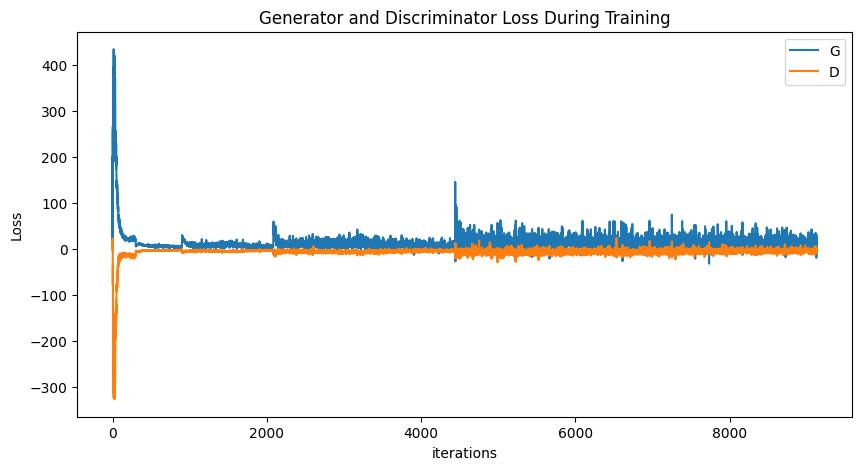

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters and global variables
dataset_dir = "/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification/Flower Classification/Training Data"
start_train_img_size = 4
lr = 1e-3
batch_sizes = [256,128,64,32,16]
channels_img = 3
z_dim = 512
w_dim = 512
in_channels = 512
lambda_gp = 10
progressive_epochs = [15] * len(batch_sizes)
gen_save_path = "/kaggle/working/stylegan_gen.pth"
disc_save_path = "/kaggle/working/stylegan_disc.pth"
training_plot_save_path = "/kaggle/working/train_plot.png"
animation_save_path = "/kaggle/working/animation.mp4"

# check_loader() 

# Define models and optimizers
gen_net = Generator(z_dim, w_dim, in_channels, channels_img).to(device)
disc_net = Discriminator(in_channels, channels_img).to(device)
gen_optimizer = optim.Adam([{"params": [param for name, param in gen_net.named_parameters() if "map" not in name]},
                     {"params": gen_net.map.parameters(), "lr": 1e-5}], lr=lr, betas=(0.0, 0.99))
disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(0.0, 0.99))

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

# Monitor Progress
progress = list()
fixed_noise = torch.randn(50, z_dim, device=device)
fixed_labels = []
for i in range(5):
    lab = [0 if j != i else 1 for j in range(5)]
    lab = lab*10
    fixed_labels.append(lab)
fixed_labels = torch.Tensor(fixed_labels).view(50, 5).float().to(device)

# Training loop
gen_net.train()
disc_net.train()
step = int(math.log2(start_train_img_size / 4))
for num_epochs in progressive_epochs[step:]:
    alpha = 1e-7
    
    loader, dataset = get_loader(4*2**step)
    print("Curent image size: " + str(4*2**step))

    for epoch in range(num_epochs):
        # print(f"Epoch [{epoch + 1}/{num_epochs}")

        loop = tqdm(loader, leave=True)

        for batch_idx, (real_images, labels) in enumerate(loop):
            real_images = real_images.to(device)
            current_batch_size = real_images.shape[0]
            noise = torch.randn(current_batch_size, z_dim).to(device)
            labels = labels.to(device).to(torch.float32)
#             print(labels.dtype)
#             print(real_images.shape, labels.shape)
            
            fake = gen_net(noise, labels, alpha, step)
            real_output = disc_net(real_images, labels, alpha, step)
            fake_output = disc_net(fake.detach(), labels, alpha, step)

            grad_penalty = gradient_penalty(disc_net, labels, real_images, fake, alpha, step, device)
            disc_loss = (-(torch.mean(real_output)-torch.mean(fake_output)) + lambda_gp*grad_penalty + (0.001)*torch.mean(real_output**2))

            disc_net.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            gen_fake = disc_net(fake, labels, alpha, step)
            gen_loss = -torch.mean(gen_fake)

            gen_net.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            alpha += current_batch_size/(progressive_epochs[step]*0.5*len(dataset))
            alpha = min(alpha,1)

            loop.set_postfix(grad_penalty = grad_penalty.item(), disc_loss = disc_loss.item())
        
            # Training Update
            if batch_idx % 50 == 0:
                print(f"[{epoch}/{num_epochs}][{batch_idx}/{len(loader)}]\tLoss_D: {disc_loss.item()}\tLoss_G: {gen_loss.item()}")

            # Tracking loss
            G_losses.append(gen_loss.item())
            D_losses.append(disc_loss.item())

            # Tracking Generator Progress
            if (iters%50 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(loader)-1)):
                with torch.no_grad():
                    fake = gen_net(fixed_noise, fixed_labels, alpha, step).detach().cpu()
                progress.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))

            iters += 1

#     generate_examples(gen_net, step)
    step += 1

# Save generator
torch.save(gen_net, gen_save_path)
torch.save(disc_net, disc_save_path)

# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()